In [0]:
!chmod +x get_data.sh

In [0]:
!./get_data.sh

In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.models.unet import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image
import re
from fastai.callbacks import Hooks
from fastai.callbacks.hooks import *

# 1. Getting the paths of the images

In [0]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [0]:
paths = getListOfFiles('data')

In [0]:
videos = []
for path in paths:
    videos.append(re.findall(r'.*/(.*)/.*',path)[0])

#videos = list(set(videos))

In [5]:
io.imread(paths[0]).shape

(288, 352, 3)

# 2. Creating the Datasets, Dataloaders and Databunch

In [0]:
#this class for videos that need more than one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.nblocks = 6 #for 720x480 videos
        self.h_steps = 3 #we can fit 3 blocks horizontally
        self.v_steps = 2 #we can fit 2 blocks vertically
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            self.spaths.extend(aux)

    def __len__(self): return (len(self.paths) - self.n_ref)*6
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx_frame = idx//self.nblocks 
        paths = self.spaths[idx_frame:idx_frame+self.n_ref:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(io.imread(path))
                 
        idx_block = idx%self.nblocks #indicates which block I'm trying to predict
                 
        #apply the transforms to the frames         
        if self.tfms: 
            for frame in frames:
                frame = self.tfms(Image.fromarray(frame))
                start_h_mult = idx_block % self.h_steps
                start_v_mult = idx_block % self.v_steps
                frame = frame[:,240*start] #TODO

In [0]:
#this class for videos that need only one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None,valid=False,valid_pct=0.2):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.valid = valid
        self.valid_pct = valid_pct
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            nframes = len(aux)
            if not self.valid: self.spaths.extend(aux[:int(nframes*(1-self.valid_pct))])
            if self.valid: self.spaths.extend(aux[-int(nframes*(self.valid_pct)):])
            self.spaths.extend(aux)

    def __len__(self): return len(self.spaths) - self.n_ref
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        paths = self.spaths[idx:idx+self.n_ref+1:1] #the last one is the target
        #import pdb;pdb.set_trace()
        
        frames = []
        for path in paths:
            frames.append(io.imread(path))
                         
        #apply the transforms to the frames         
        if self.tfms:
            tfms_frames = []
            for frame in frames:
                tfms_frames.append(self.tfms(Image.fromarray(frame)))
        
        sample = (torch.cat(tfms_frames[:self.n_ref]),tfms_frames[-1])
        return sample
    
    def show(self,idx):
        
        x,y = self.__getitem__(idx)
        imgs = []
        idx = 0
        for _ in range(int(x.shape[0]/3)): 
            imgs.append(x[idx:idx+3])
            idx+=3
        imgs.append(y)
        fig=plt.figure(figsize=(10, 10))
        f, ax = plt.subplots(1,len(imgs))
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        for i,frame in enumerate(imgs):
            x = (frame.numpy().transpose((1,2,0))*stds + means)*255
            ax[i].imshow(x.astype(np.uint8))
            if i < len(imgs)-1:
                ax[i].title.set_text('Ref Frame {}'.format(i))
            else:
                ax[i].title.set_text('Target Frame')

In [0]:
tfms = transforms.Compose([
        transforms.CenterCrop((288,352)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #imagenet stats

In [0]:
train_ds = CustomDataset(paths,tfms=tfms,valid=False,n_ref=1,block_size=(288,352))
valid_ds = CustomDataset(paths,tfms=tfms,valid=True,n_ref=1,block_size=(288,352))

<Figure size 720x720 with 0 Axes>

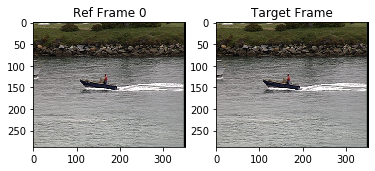

In [53]:
train_ds.show(0)

<Figure size 720x720 with 0 Axes>

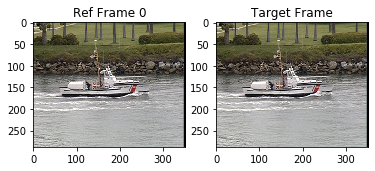

In [54]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds,batch_size=4, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=4, shuffle=True, num_workers=2)

In [0]:
data = DataBunch(train_dl,valid_dl)

# 3. Creating the model

## 3.1. Defining the encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self,model,ndims=512, n_ref=1):
        super(Encoder,self).__init__()
        self.cnn_encoder = nn.Sequential(*list(model.children())[:-1])
        if n_ref != 1:
            self.cnn_encoder[0] = nn.Conv2d(n_ref*3,64,kernel_size=(7,7),stride=(2,2), padding=(3,3),bias=False)
        self.lstm = nn.LSTM(ndims,ndims)
        self.lamb_lstm = Lambda(lambda x: x.squeeze(3).transpose(1,2))
        self.lamb_out = Lambda(lambda x: x[0].transpose(1,2).unsqueeze(3) if isinstance(x,tuple) else x.transpose(1,2).unsqueeze(3))
        #self.layers = nn.Sequential(self.cnn_encoder, self.lamb_lstm, self.lstm, self.lamb_out)
        
    def forward(self,x):
        cnn_encodings = self.cnn_encoder(x)
        cnn_encodings = self.lamb_lstm(cnn_encodings)
        out,_ = self.lstm(cnn_encodings)
        out = self.lamb_out(out)
        return out

    #def __getitem__(self,idx): return self.layers[idx]

In [136]:
encoder = Encoder(models.vgg16_bn(pretrained=True),n_ref=1)
#encoder = nn.Sequential(encoder)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
x,y = next(iter(train_dl))

In [139]:
encoder.cnn_encoder(x).shape

torch.Size([4, 512, 7, 7])

In [138]:
out = encoder(x)
out.shape

RuntimeError: ignored

## 3.2. Putting a Unet Decoder on top of the Encoder

In [0]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [0]:
class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder.cnn_encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder.cnn_encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder.cnn_encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()


In [0]:
model = DynamicUnet(encoder, n_classes=3, img_size=(288,352),self_attention=True, bottle=True)

In [109]:
model(x).shape

torch.Size([4, 3, 288, 352])

## 3.3. Another option for a decoder

In [0]:
out = encoder(x)

In [131]:
out.shape

torch.Size([4, 512, 1, 1])

In [135]:
ni = 512
conv1 = nn.Conv2d(ni,256,1,padding=5)
bn1 = nn.BatchNorm2d(256)
conv2 = nn.Conv2d(256,128,1,padding=5)
bn2 = nn.BatchNorm2d(128)
conv3 = nn.Conv2d(128,64,1,padding=5)
bn3 = nn.BatchNorm2d(64)

out1 = bn1(conv1(out))
out2 = bn2(conv2(out1))
out3 = bn3(conv3(out2))

out3.shape

torch.Size([4, 64, 31, 31])

In [0]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder,self).__init__()
        self.lin = nn.Linear(512,)



# 4. Creating the Learner and Training the Model

In [71]:
l = mae(x,y)
l

tensor(0.1188)

In [74]:
m = torch.abs(x-y).max()
m

tensor(0.1188)

In [0]:
def custom_loss(y_pred,targ):
    loss = mae(y_pred,targ)
    m = torch.abs(x-y).max()
    return loss*m

In [0]:
learn = Learner(data,model,loss_func=nn.L1Loss(), callback_fns=ShowGraph)

In [0]:
#in the encoder only have to fit the lstm
for child in learn.model.layers[0].named_children():
    if child[0] == 'lstm':
        for params in child[1].parameters():
            params.requires_grad = True
    else:
        for params in child[1].parameters():
            params.requires_grad = False

#I have to fit the decoder
for child in learn.model.layers[1:].children():
    for params in child.parameters():
        params.requires_grad = True

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


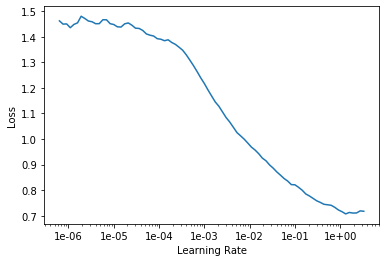

In [112]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.328931,0.125451,04:18


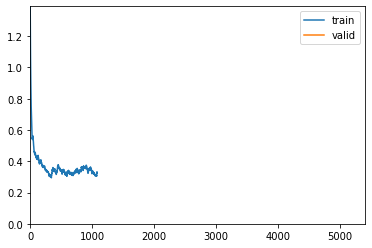

Better model found at epoch 0 with valid_loss value: 0.1254509836435318.


KeyboardInterrupt: ignored

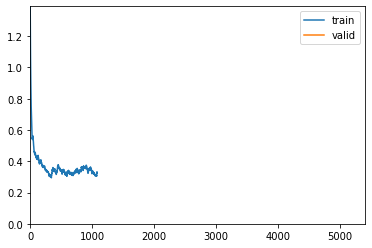

In [113]:
learn.fit_one_cycle(5,max_lr=1e-2,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')])

In [0]:
def show_results(learn,figsize=(10,10)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0][-3:].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    inp = inp.astype('uint8')
    target = target.astype('uint8')
    pred = pred.astype('uint8')
    inp = inp.astype('float32')
    target = target.astype('float32')
    pred = pred.astype('float32')

    mse_pred = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr_pred = 10*np.log10(255/mse_pred)

    print('MSE for pred:',mse_pred)
    print('PSNR for pred:', psnr_pred)

    mse_inp = np.sum(((inp - target)**2))/(inp.shape[0]*inp.shape[1]*inp.shape[2])
    psnr_inp = 10*np.log10(255/mse_inp)

    print('MSE for input:',mse_inp)
    print('PSNR for input:',psnr_inp)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
_ = learn.load('stage-1')

MSE for pred: 671.8700547138047
PSNR for pred: -4.20745104557599
MSE for input: 317.6444654882155
PSNR for input: -0.9540111232762081


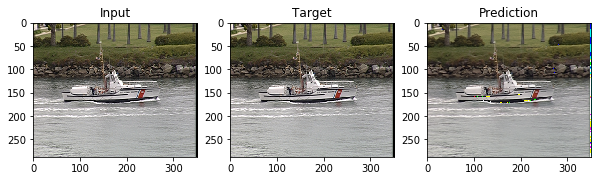

In [101]:
show_results(learn)